In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set crypto variable
crypto = 'PEPE'

# Create crypto df
crypto_df = f'{crypto}_df'.lower()

In [5]:
# Store the crypto data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.
crypto_df = pd.read_csv(
    f'~/crypto-forecast/Resources/{crypto}-USD.csv',
    index_col='Date',
    parse_dates=True
).dropna()

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-04-17,0.0,0.0,0.0,0.0,0.0,46385210.0
2023-04-18,0.0,0.0,0.0,0.0,0.0,73954201.0
2023-04-19,0.0,0.0,0.0,0.0,0.0,170056322.0
2023-04-20,0.0,0.0,0.0,0.0,0.0,120513516.0
2023-04-21,0.0,0.0,0.0,0.0,0.0,98777429.0


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-14,0.000010,0.000011,0.000010,0.000011,0.000011,3.718546e+09
2024-05-15,0.000011,0.000012,0.000010,0.000011,0.000011,2.940933e+09
2024-05-16,0.000011,0.000011,0.000010,0.000010,0.000010,1.552052e+09
2024-05-17,0.000010,0.000010,0.000010,0.000010,0.000010,1.059531e+09
2024-05-19,0.000010,0.000010,0.000009,0.000010,0.000010,8.710486e+08


In [6]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

1e-05

In [7]:
crypto_df.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.991182,0.989813,0.986853,0.986853,0.721786
High,0.991182,1.000000,0.985209,0.993087,0.993087,0.773342
Low,0.989813,0.985209,1.000000,0.989731,0.989731,0.708497
Close,0.986853,0.993087,0.989731,1.000000,1.000000,0.752809
Adj Close,0.986853,0.993087,0.989731,1.000000,1.000000,0.752809
Volume,0.721786,0.773342,0.708497,0.752809,0.752809,1.000000


In [8]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [9]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2023-04-17,0.000000,4.638521e+07
2023-04-18,0.000000,7.395420e+07
2023-04-19,0.000000,1.700563e+08
2023-04-20,0.000000,1.205135e+08
2023-04-21,0.000000,9.877743e+07
...,...,...
2024-05-14,0.000011,3.718546e+09
2024-05-15,0.000011,2.940933e+09
2024-05-16,0.000010,1.552052e+09


In [10]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [11]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2023-06-05,0.000001,199417484.0,0.000001,0.000002,0.000001
2023-06-06,0.000001,266713275.0,0.000001,0.000002,0.000001
2023-06-07,0.000001,169068661.0,0.000001,0.000002,0.000001
2023-06-08,0.000001,110836939.0,0.000001,0.000001,0.000001
2023-06-09,0.000001,159479450.0,0.000001,0.000001,0.000001


,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-05-14,0.000011,3.718546e+09,0.000009,0.000007,0.000007
2024-05-15,0.000011,2.940933e+09,0.000009,0.000008,0.000007
2024-05-16,0.000010,1.552052e+09,0.000009,0.000008,0.000007
2024-05-17,0.000010,1.059531e+09,0.000009,0.000008,0.000007
2024-05-19,0.000010,8.710486e+08,0.000010,0.000008,0.000008


<Axes: xlabel='Date'>

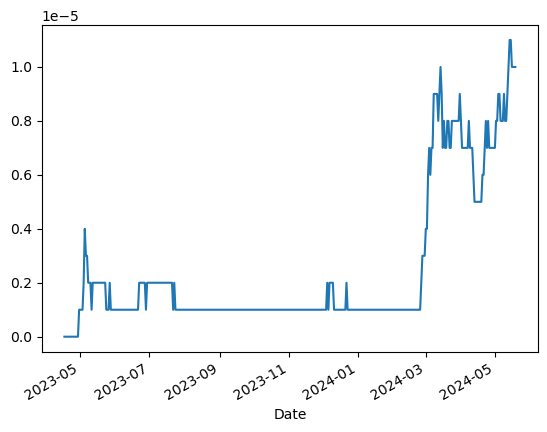

In [12]:
# Plot Close
df_close['Close'].plot()

In [13]:
## Create a Time Series Model with Prophet

In [14]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [15]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2023-04-17,0.000000,4.638521e+07
1,2023-04-18,0.000000,7.395420e+07
2,2023-04-19,0.000000,1.700563e+08
3,2023-04-20,0.000000,1.205135e+08
4,2023-04-21,0.000000,9.877743e+07
...,...,...,...
393,2024-05-14,0.000011,3.718546e+09
394,2024-05-15,0.000011,2.940933e+09
395,2024-05-16,0.000010,1.552052e+09
396,2024-05-17,0.000010,1.059531e+09


In [16]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [17]:
# Fit the time-series model.
crypto_model.fit(df_close)

18:50:40 - cmdstanpy - INFO - Chain [1] start processing
18:50:40 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
483,2024-08-13
484,2024-08-14
485,2024-08-15
486,2024-08-16
487,2024-08-17


In [19]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
458,2024-07-19,0.000014,0.000013,0.000016,0.000014,0.000015,3.687457e-08,3.687457e-08,3.687457e-08,3.687457e-08,3.687457e-08,3.687457e-08,0.0,0.0,0.0,0.000014
459,2024-07-20,0.000014,0.000013,0.000016,0.000014,0.000015,-4.204928e-08,-4.204928e-08,-4.204928e-08,-4.204928e-08,-4.204928e-08,-4.204928e-08,0.0,0.0,0.0,0.000014
460,2024-07-21,0.000014,0.000013,0.000016,0.000014,0.000015,6.338366e-08,6.338366e-08,6.338366e-08,6.338366e-08,6.338366e-08,6.338366e-08,0.0,0.0,0.0,0.000014
461,2024-07-22,0.000014,0.000013,0.000016,0.000014,0.000015,-3.266283e-10,-3.266283e-10,-3.266283e-10,-3.266283e-10,-3.266283e-10,-3.266283e-10,0.0,0.0,0.0,0.000014
462,2024-07-23,0.000014,0.000013,0.000016,0.000014,0.000015,-2.140968e-08,-2.140968e-08,-2.140968e-08,-2.140968e-08,-2.140968e-08,-2.140968e-08,0.0,0.0,0.0,0.000014
463,2024-07-24,0.000015,0.000013,0.000016,0.000014,0.000015,-5.993471e-08,-5.993471e-08,-5.993471e-08,-5.993471e-08,-5.993471e-08,-5.993471e-08,0.0,0.0,0.0,0.000014
464,2024-07-25,0.000015,0.000013,0.000016,0.000014,0.000015,2.346209e-08,2.346209e-08,2.346209e-08,2.346209e-08,2.346209e-08,2.346209e-08,0.0,0.0,0.0,0.000015
465,2024-07-26,0.000015,0.000013,0.000016,0.000014,0.000015,3.687457e-08,3.687457e-08,3.687457e-08,3.687457e-08,3.687457e-08,3.687457e-08,0.0,0.0,0.0,0.000015
466,2024-07-27,0.000015,0.000013,0.000016,0.000014,0.000015,-4.204928e-08,-4.204928e-08,-4.204928e-08,-4.204928e-08,-4.204928e-08,-4.204928e-08,0.0,0.0,0.0,0.000015
467,2024-07-28,0.000015,0.000013,0.000016,0.000014,0.000015,6.338366e-08,6.338366e-08,6.338366e-08,6.338366e-08,6.338366e-08,6.338366e-08,0.0,0.0,0.0,0.000015


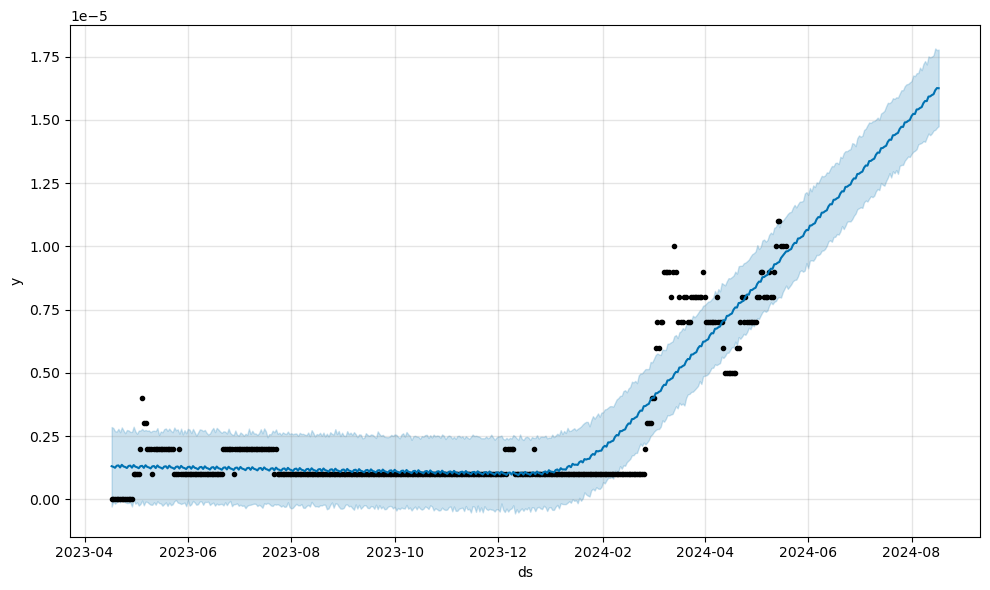

In [20]:
# Plot the Prophet predictions for the data
fig1 = crypto_model.plot(crypto_forecast)

In [21]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [22]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-05-20,0.000010,0.000008,0.000011
2024-05-21,0.000010,0.000008,0.000011
2024-05-22,0.000010,0.000008,0.000011
2024-05-23,0.000010,0.000009,0.000012
2024-05-24,0.000010,0.000009,0.000012
...,...,...,...
2024-08-13,0.000016,0.000014,0.000018
2024-08-14,0.000016,0.000015,0.000018
2024-08-15,0.000016,0.000015,0.000018


In [23]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

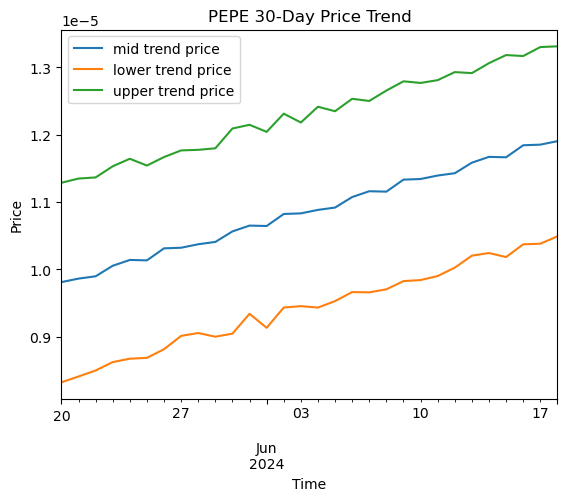

In [24]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

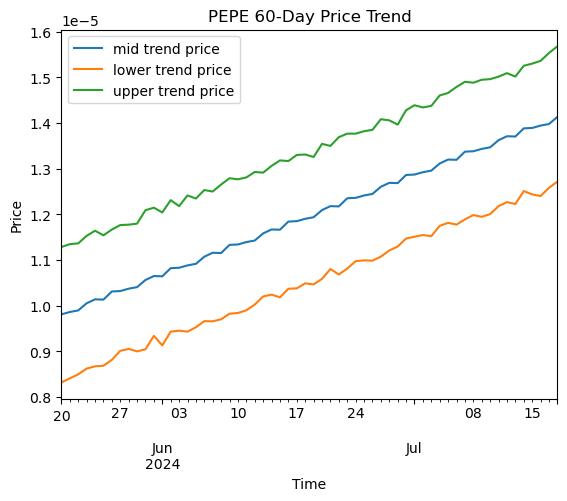

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

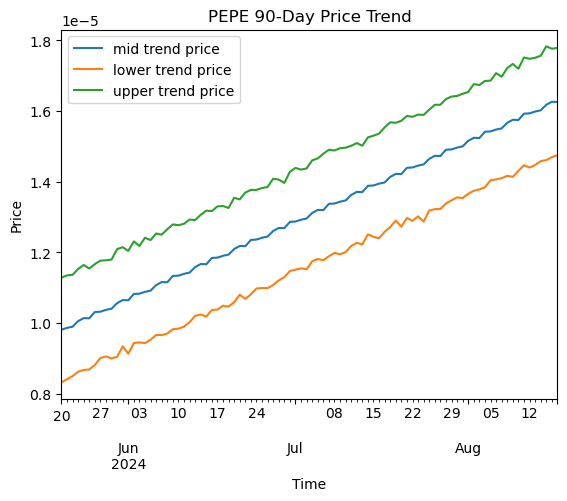

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend')    
plt.show()

In [27]:
# Retrieve last closing price
last_close_price

1e-05

In [28]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

9.810282452121526e-06

In [29]:
# Retrieve mid trend price in 30 days
mid_trend_price_in_30 = crypto_forecast['mid trend price'].iloc[-60]
mid_trend_price_in_30

1.1936552667556517e-05

In [30]:
# Retrieve mid trend price in 60 days
mid_trend_price_in_60 = crypto_forecast['mid trend price'].iloc[-30]
mid_trend_price_in_60

1.4219240250195796e-05

In [31]:
# Retrieve mid trend price in 90 days
mid_trend_price_in_90 = crypto_forecast['mid trend price'].iloc[-1]
mid_trend_price_in_90

1.6253332092778226e-05

In [32]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30.round(3)

0.194

In [33]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60.round(3)

0.422

In [34]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90.round(3)

0.625

In [35]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

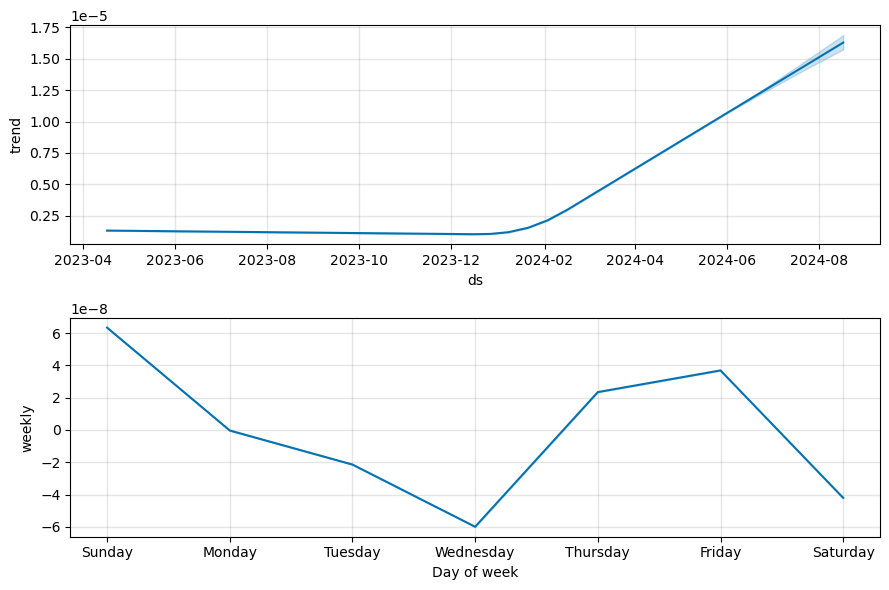

In [36]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig2 = crypto_model.plot_components(crypto_forecast)

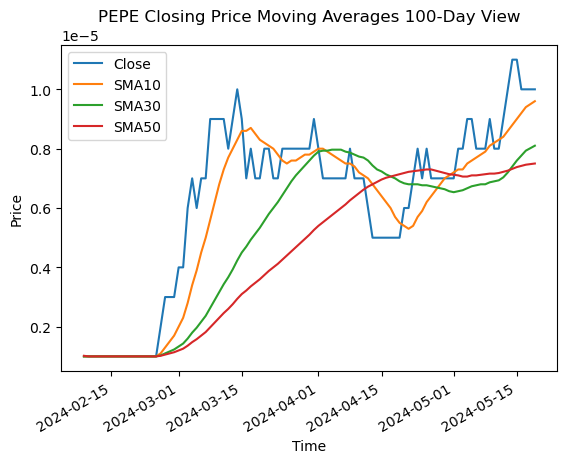

In [37]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

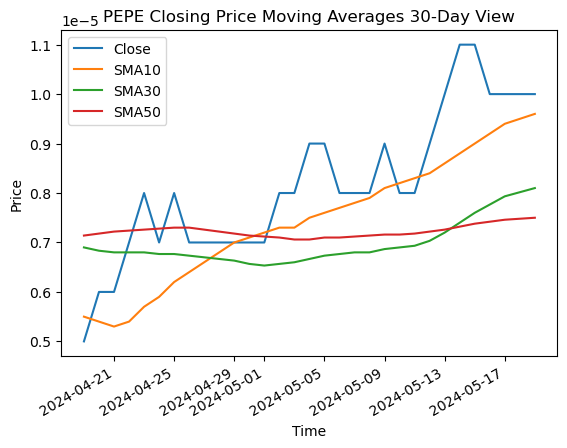

In [38]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View')    
plt.show()

In [39]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
#file_name = f'{crypto} '+str_current_datetime+".txt"
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-05-19
File created :  2024-05-19.csv


In [40]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [41]:
f = open(f'{file_name}', "r")
print(f.read())

ADA,0.481067,-0.006935356560101691,-0.07859463805561773,0.23472349758660838
BNB,580.305542,-0.34535988531321604,-0.3403273855834782,-0.29106901029282883
BONK,2.8e-05,0.1292127878224536,0.2630430622648412,0.38814028120395916
BTC,67051.88,-0.23323891802030206,-0.21230307524907965,-0.17587733204204037
DOGE,0.152578,-0.2473798803862568,-0.3174264585592441,-0.169114542247355
ETH,3094.12,-0.05599603182651869,-0.04100077989984452,0.04719570091164238
PEPE,1e-05,0.1936552667556517,0.4219240250195795,0.6253332092778225

